# PyTorch workflow

What were convering 
1. data preparation
2. build model
3. fitting the model to data (training)
4. making predictions and evaluating a model (inference)
5. saving and loading a model
6. putting it all together

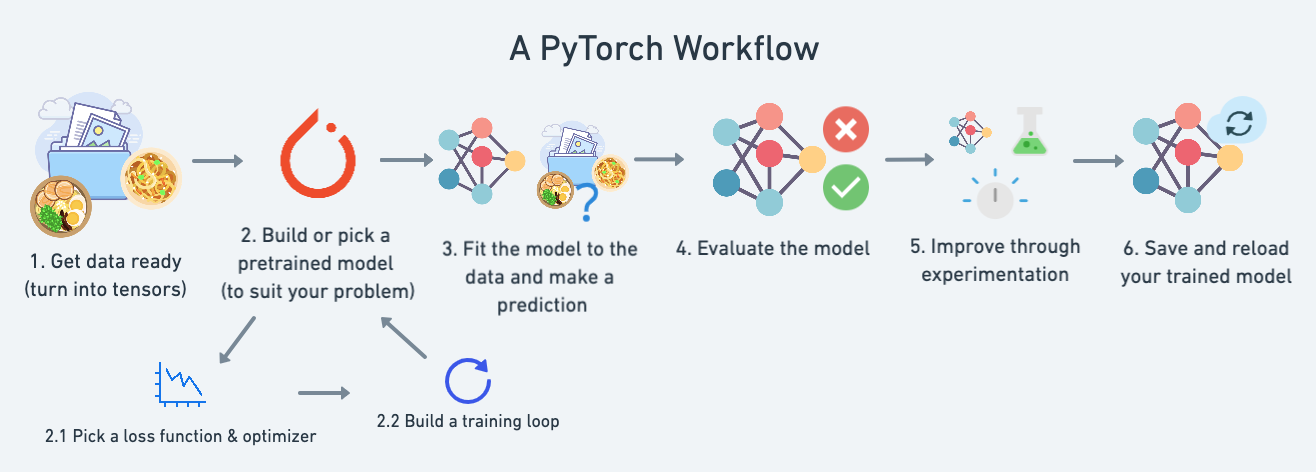

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural network
import matplotlib.pyplot as plt

## 1. Data preparation

Data can be almost anything... in machine learning.

* Excel speadsheet
* Images of any kind
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *know* data using the linear regression formula.

A linear regression with *known* parameters.

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create some data using linear regression y = weight*X + bias
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # capital X is for a tensor or a matrix, add a dimension in dimension one
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

### Split data into training and test data sets

In [4]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [5]:
def plot_prediction(train_data = X_train, train_lables = y_train, 
                    test_data = X_test, test_lables = y_test,
                    predictions=None):
  """ 
  plots trainning data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_lables, c="b", s=4, label="Training data")

  # plot test data in green
  plt.scatter(test_data, test_lables, c="g", s=4, label="Testting data")

  # Are there predictions?
  if predictions is not None:
    # plot predictions if thet exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # show the legend
  plt.legend(prop={"size": 14});


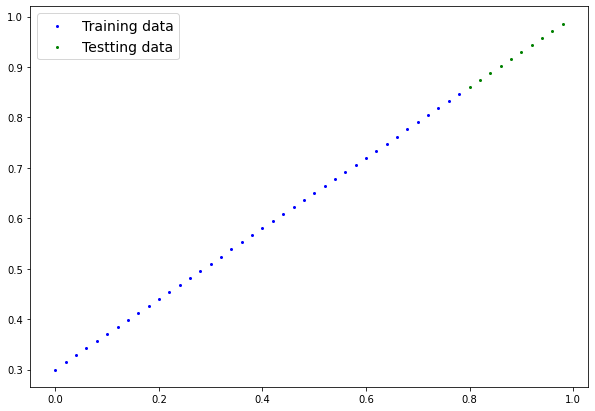

In [6]:
plot_prediction();

## 2. Build model

nn.module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html

nn.parameter: https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html?highlight=parameter#torch.nn.parameter.Parameter


What our model does:
* Start with random values (weight & bias)
* Look at the training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?
1. Gradient descent: https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation: https://www.youtube.com/watch?v=Ilg3gGewQ5U

Notes: Backpropagation is an algorithm used for training artificial neural networks. It is a supervised learning algorithm that uses a gradient descent optimization technique to update the weights and biases of the network in order to minimize the error between the predicted output and the actual output.

By **going backwards**, we take the gradients of the loss function with respect to each parameter in our model. That's what happens when we call `loss.backward()`. PyTorch dose that for us behind the scenes.



In [7]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### PyTorch model building essentials

* **torch.nn** - contains all of the budilings for computational graphs (aneural network can be considered a computational graph)
* **torch.nn.Parameter** - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us if you subcalss it, you should overwrite `forward()`
* **torch.optim** - this where the optimizers in PyTorch live, they will help with gradient descent
* **def forward()** - all nn.Module subclasses require you to overwrite `forward()`, this method defines what happens in the forward computation

In [8]:
torch.manual_seed(42)
torch.randn(1)

tensor([0.3367])

### Check the contents of our PyTorch model

Let's see what's indise...
Using `.parameters()`

In [9]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
weight, bias

(0.7, 0.3)

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [12]:
X_test, y_test # ideal model values

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]), tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [13]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

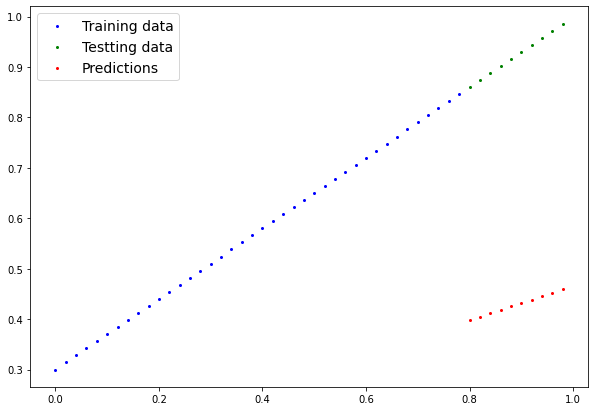

In [14]:
plot_prediction(predictions=y_preds)
# this is a poor representation, we can improve this

## 3. Train model

The whole idea of training for a model to move from some *unknown* parameters(these amy be random) to some *known* parameters. In other words, from a poor representation of data to a better representation of the data.

**Loss function**: a function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

**Optimizer**: take into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function.

- Inside the optimizer, you'll often have to set two parameters:
  - **params** - the model parameters you'd like to optimize, e.g. `params=model_0.parameters()`
  - **lr(learning rate)** - how big/small the optimizer changes the parameters with each step(a small `lr` results in samll changes, a large `lr` results in large changes)

Note: Loss function may also be called cost function in different areas. 

e.g L1LOSS function - 
create a criterion that measures the mean absolute error (MAE) between each element in the input `x` and traget `y`.

More loss functions/optimizer can be found:
https://pytorch.org/docs/stable/nn.html


https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer

Specifically for PyTtorch, we need:
**- A training loop**
**- A testing loop**

In [15]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [16]:
# A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor
model_0.state_dict() 

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# Setup a loss function
loss_fn = nn.L1Loss() # mean absolute error (MAE) 

# Set up an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr=learning rate how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time)



**Which loss function and optimizer should I use?**

This will be problem specific.

For example, for a regression problem (like above one), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss)



### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. loop through the data and do...
1. forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. calculate the loss (compare forward pass predicitons to ground truth labels)
3. optimizer zero grad
4. loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [18]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [19]:
torch.manual_seed(27)
# An epoch is one loop through the data...(this is a hyperparameter because we've set it ourself)
epochs = 100

### Training
# 0. loop through the data
for epoch in range(epochs):
  #  Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train) # differences between predictions and ideal y values
  #print(f"Loss:{loss}")
  
  # 3. Optimizer zero grad, zero the gradients of the optimizer(they accumulate by default)
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # update the model's parameters. by default how the optimizer changes will accumulate through the loop. So we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turn off different settings in the model not needed for evaluation/testing
  with torch.inference_mode(): # we don't need learning model when doing testing. turn off gradient tracking mode & a couple more things behind the scenes 
    # 1. do the forward pass
    test_pred = model_0(X_test)

    # 2. calculate the test loss
    test_loss = loss_fn(test_pred, y_test)
  
  # Print out what happenin every ten iterations
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")  
    print(model_0.state_dict()) # print results of parameters loss is deduced after each iteration

  

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [20]:
# Loss: 0.017245199531316757
# OrderedDict([('weights', tensor([0.6006])), ('bias', tensor([0.3418]))])

In [21]:
# Ideal weight and bias
weight, bias

(0.7, 0.3)

In [22]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

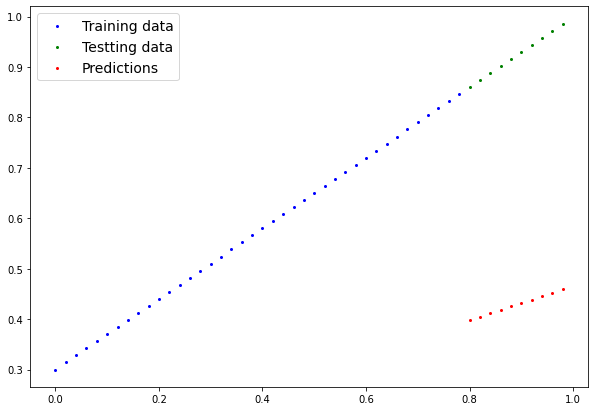

In [23]:
# Visualization of initial predictions starting with random values 
plot_prediction(predictions=y_preds) 

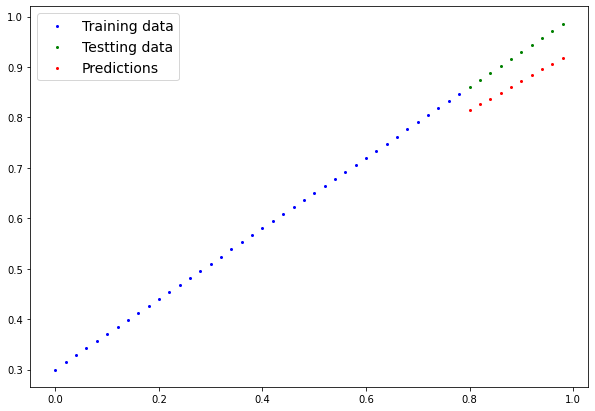

In [24]:
plot_prediction(predictions=y_preds_new)

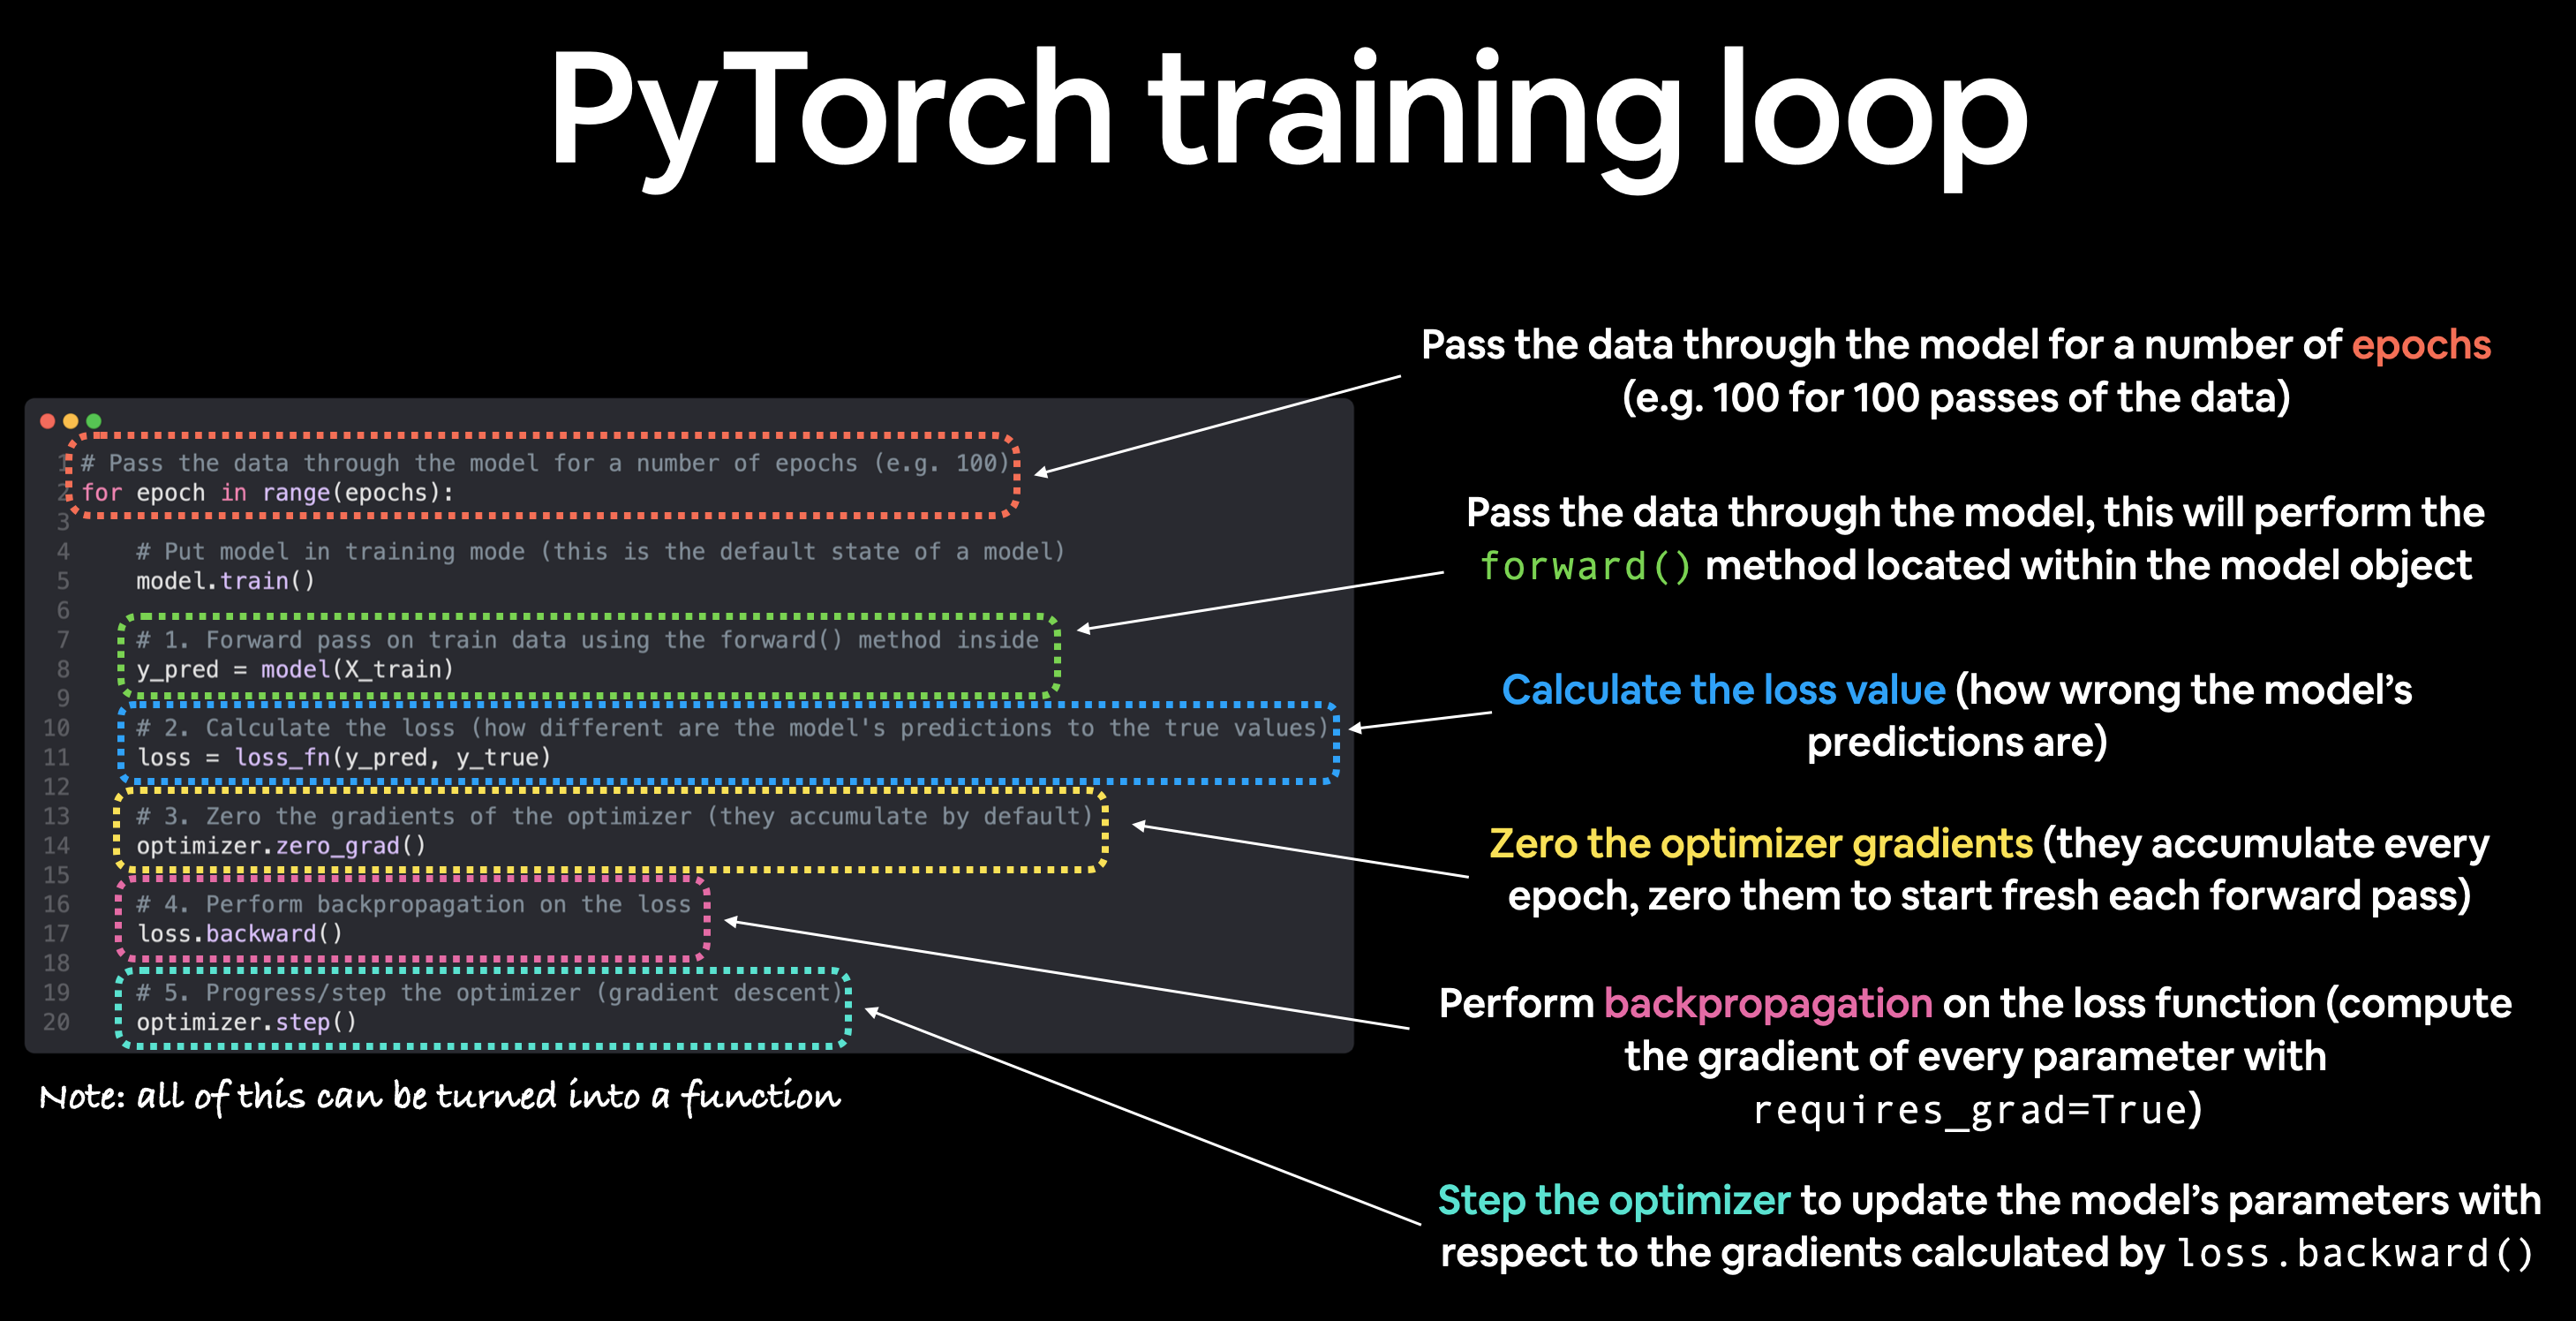

**Gradient descenting**

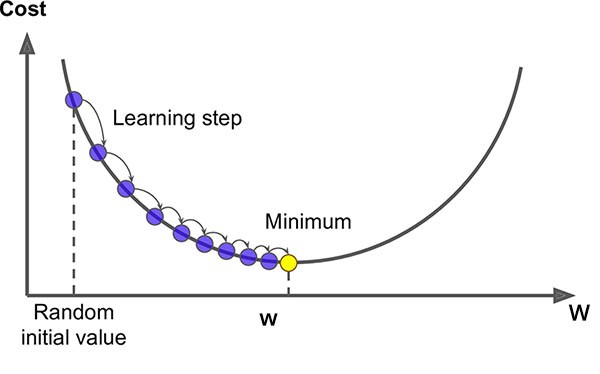

- Loss function curve
- Learning rate scheduling
- Torch autograd

**`model.train() & model.eval()`**

There are two ways of letting the model know your intention i.e do you want to train the model or do you want to use the model to evaluate. 

In case of `model.train()` the model knows it has to learn the layers and when we use `model.eval()` it indicates the model that nothing new is to be learnt and the model is used for testing. 

`model.eval()` is also necessary because in pytorch if we are using batchnorm and during test if we want to just pass a single image, pytorch throws an error if `model.eval()` is not specified.

## Saving a model in PyTorch

Three methods for saving and loading models in PyTorch:
1. `torch,save()` - save a PyTorch object in Python's pickle format
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary

PyTorch save & load tutorial -
https://pytorch.org/tutorials/beginner/saving_loading_models.html

- How to save from google colab to google drive?

In [25]:
model_0.state_dict() # hold all the states of model_0

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [28]:
# Saving our PyTorch model
from pathlib import Path # a module for dealing with writing file paths

# 1. Create models directory
MODEL_PATH = Path("models") # saving all of our models to "models" file
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [30]:
!ls - l models

ls: cannot access '-': No such file or directory
ls: cannot access 'l': No such file or directory
models:
01_pytorch_workflow_model_0.pth


## Loading a PyTorch model
Since we saved our model's `state_dict()` rather the entire model. We'll create **a new instance of our model class **and load the saved `state_dict()` into that.

In [33]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [34]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel() # this is a subset calss of nn.Module, we can use nn.Module.load_state_dict() to load

# Load the saved state_dict of model_0(this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [35]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [36]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds


tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [37]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [38]:
# Make loaded model preds with original model preds
loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting it all together

Let's go back through the steps above and see it all in one place


In [39]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.1+cu116'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it. If no GPU is available, the code will default to using CPU.

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### 6.1 Data

In [60]:
# Creating some data using  a linear regression y = weight*X + bias
weight = 0.7
bias = 0.3

# Creating a tensor with 0-1 interval
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
print(X, X.shape)

y = weight * X + bias

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800],
        [0.2000],
        [0.2200],
        [0.2400],
        [0.2600],
        [0.2800],
        [0.3000],
        [0.3200],
        [0.3400],
        [0.3600],
        [0.3800],
        [0.4000],
        [0.4200],
        [0.4400],
        [0.4600],
        [0.4800],
        [0.5000],
        [0.5200],
        [0.5400],
        [0.5600],
        [0.5800],
        [0.6000],
        [0.6200],
        [0.6400],
        [0.6600],
        [0.6800],
        [0.7000],
        [0.7200],
        [0.7400],
        [0.7600],
        [0.7800],
        [0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]]) torch.Size([50, 1])


In [63]:
# Split data into training data set and test data set
split_size = int(0.8*len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

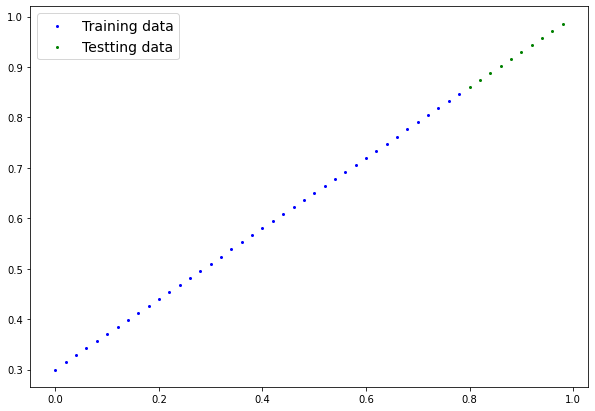

In [65]:
# Plot data for training data and testing data
plot_prediction(X_train, y_train, X_test, y_test) 

### 6.2 Building a linear model

`linear_layer()` - 
https://pytorch.org/docs/stable/nn.html#linear-layers

In [67]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # use nn.Linear() for creating the model parameters/also called: linear transformation to the incoming data:
    self.linear_layer = nn.Linear(in_features=1, out_features=1) # since one x tensor input, one y tensor output
  
  # forward() defines th ecomputation in the model
  def forward(self, x: torch.tensor):
    return self.linear_layer(x)

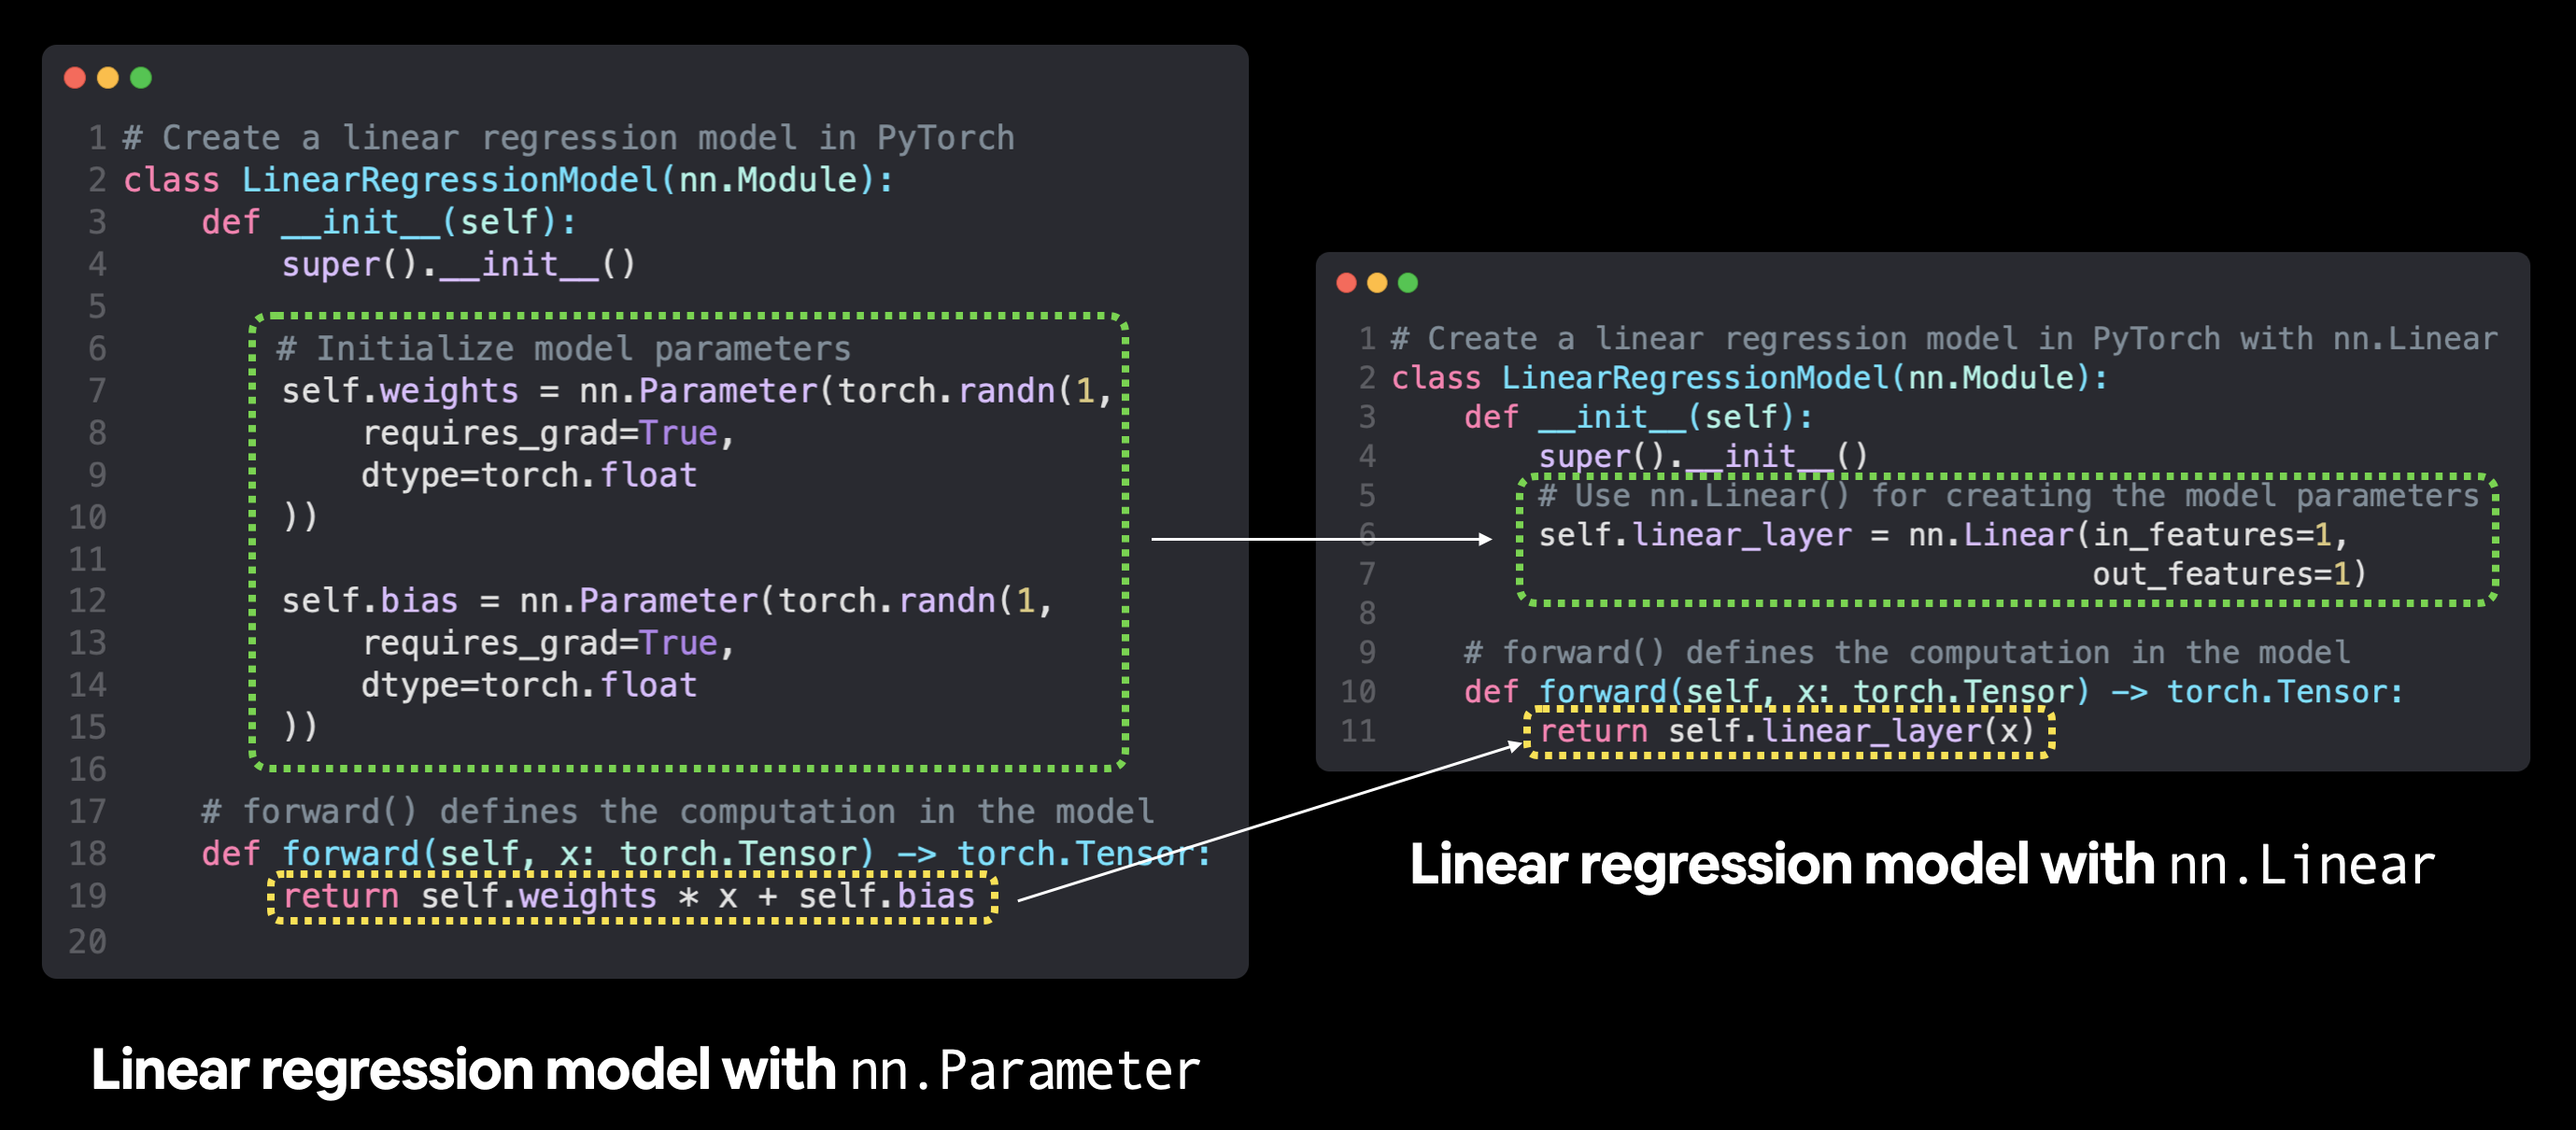

In [73]:
torch.manual_seed(23)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.1435]])),
              ('linear_layer.bias', tensor([-0.4223]))]))

In [85]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [88]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [89]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

### 6.3 Training

For training we need:
1. Loss function
2. Optimizer
3. Training loop
4. Testing loop

In [93]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01) # update the parameters based on the computed gradients

torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):
  # 1. setup training mode
  model_1.train()

  # 2. forward pass
  y_pred = model_1(X_train)

  # 3. calculating loss for trainning data set
  train_loss = loss_fn(y_pred, y_train)

  # 4. optimizer zero gradient, zero the gradients of the optimizer(they accumulate by default)
  optimizer.zero_grad()

  # 5. perform backpropagation 
  train_loss.backward()

  # 6. optimizer step
  optimizer.step()

  ### testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)
  
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {test_loss}")



Epoch: 0 | Train loss: 0.05628515034914017 | Test loss: 0.13101787865161896
Epoch: 10 | Train loss: 0.05285188555717468 | Test loss: 0.1227453351020813
Epoch: 20 | Train loss: 0.04941307753324509 | Test loss: 0.11447276920080185
Epoch: 30 | Train loss: 0.045983217656612396 | Test loss: 0.10688711702823639
Epoch: 40 | Train loss: 0.04254826903343201 | Test loss: 0.09861459583044052
Epoch: 50 | Train loss: 0.0391097255051136 | Test loss: 0.09102894365787506
Epoch: 60 | Train loss: 0.035681284964084625 | Test loss: 0.08275637775659561
Epoch: 70 | Train loss: 0.032244645059108734 | Test loss: 0.07448383420705795
Epoch: 80 | Train loss: 0.02880779467523098 | Test loss: 0.06689819693565369
Epoch: 90 | Train loss: 0.02537935972213745 | Test loss: 0.058625608682632446
Epoch: 100 | Train loss: 0.02194102481007576 | Test loss: 0.05035312846302986
Epoch: 110 | Train loss: 0.01850585639476776 | Test loss: 0.04276742786169052
Epoch: 120 | Train loss: 0.01507621444761753 | Test loss: 0.0344948954880

In [98]:
print(model_1.state_dict())
print(weight, bias)
# they are very close, the regression we just built is sufficient!

OrderedDict([('linear_layer.weight', tensor([[0.6942]])), ('linear_layer.bias', tensor([0.3057]))])
0.7 0.3


### Making and evaluating predictions


In [99]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8611],
        [0.8750],
        [0.8888],
        [0.9027],
        [0.9166],
        [0.9305],
        [0.9444],
        [0.9583],
        [0.9721],
        [0.9860]])

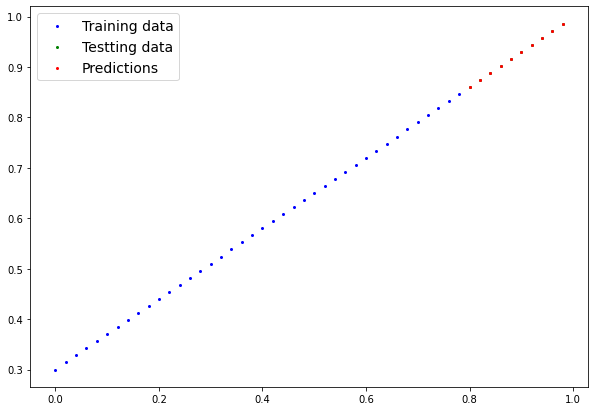

In [101]:
# Visualization for testing values 
plot_prediction(predictions=y_preds)
# Woah! Look at those red dots, they line up almost perfectly with the green dots. I guess the extra epochs helped.